# New York City Taxi Trip Duration

목차:

**[I. 데이터 불러오기 및 확인](#one)**

- [a. 데이터 불러오기 및 결측치 확인](#one-a)

**[II. EDA & FE](#two)**

- [a. 타겟 변수](#two-a)
- [b. 데이터 합치기](#two-b)
- [c. 날짜 변수](#two-c)
- [d. 거리 변수](#two-d)
- [e. 범주형 변수 원핫 인코딩](#two-e)
- [f. 상관 관계](#two-f)

**[III. 모델링](#three)**

- [a. train_test_split](#three-a)
- [b. RMSLE](#three-b)
- [c. 통계확인](#three-c)
- [d. lightgbm](#three-d)
- [e. xgboost](#three-e)

**[IV. 예측](#four)**

- [a. 앙상블](#four-a)

## I.데이터 불러오기 및 확인 <a id="one"></a>

1. 변수 | 설명
------- | -------
**id** | 각 여행에 대한 식별자
**vendor_id** | 여행 기록과 관련된 제공자를 나타내는 코드 
**pickup_datetime** | 미터가 작동 된 날짜 및 시간  
**dropoff_datetime** | 미터가 작동되지 않는 날짜 및 시간  
**passenger_count** | 차량의 승객 수 (운전자 입력 값) 
**pickup_longitude** | 미터가 사용 된 경도
**pickup_latitude** | 미터가 사용 된 위도 
**dropoff_longitude** | 미터가 사용 안 된 경도
**dropoff_latitude** | 미터가 사용 안 된 위도
**store_and_fwd_flag** | 이 플래그는 차량이 서버에 연결되어 있지 않기 때문에 공급 업체에 보내기 전에 여행 레코드가 차량 메모리에 보유되었는지 여부를 나타냅니다 (Y = 저장 및 전달, N = 저장 및 전달 여행이 아님).
**trip_duration** | 여행 시간 (초)

In [2]:
import numpy as np
import pandas as pd 
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### a. 데이터 불러오기 및 결측치 확인 <a id="one-a"></a>

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [5]:
test.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

>결측치 확인 결과 없는것으로 판단되었다.

## II. EDA & FE <a id="two"></a>

### a.타겟변수 확인 <a id="two-a"></a>

In [8]:
from scipy import stats
from scipy.stats import norm

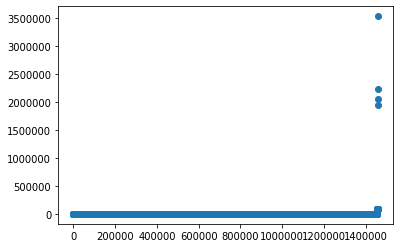

In [9]:
plt.scatter(range(train.shape[0]),np.sort(train['trip_duration']))

산점도 확인 결과 이상치가 존재 하는것 같다

>train[train.trip_duration < train.trip_duration.quantile(0.99)] 유의수준1%에 해당하는 데이터 범위를 지정한뒤에 타겟변수를 설정해주고 살펴보았더니 전보다 편중이 덜 심해진 것을 볼 수 있다.

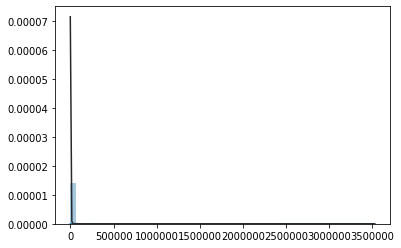

In [10]:
sns.distplot(train.trip_duration.values, fit = norm)

>distplot 확인 결과 정규성을 띄지 않으므로 멱변환은 치해준다

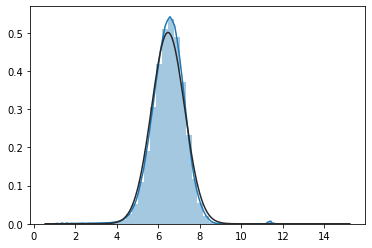

In [11]:
sns.distplot(np.log1p(train.trip_duration.values), fit = norm)

In [12]:
train['trip_duration'] = np.log(train['trip_duration'].values)

>로그 변환 후 정규성을 띄는 것을 볼 수 있으므로 타겟변수인 trip_duration 피처에 대해서 로그변환을 시켜준다

### b.데이터 합치기 <a id="two-b"></a>

In [13]:
feature_names=list(test)
df_train=train[feature_names]
df=pd.concat((df_train, test))

In [14]:
print(train.shape, test.shape, df.shape)

(1458644, 11) (625134, 9) (2083778, 9)


> 데이터 전처리를 편리하게 하기 위해서 train데이터와 test 데이터를 합쳤다.

In [15]:
df.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N


### c.날짜 변수 <a id="two-c"></a>

In [16]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [17]:
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['weekday'] = df['pickup_datetime'].dt.weekday
df['hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek

In [18]:
df.drop(['pickup_datetime'], axis=1, inplace=True)

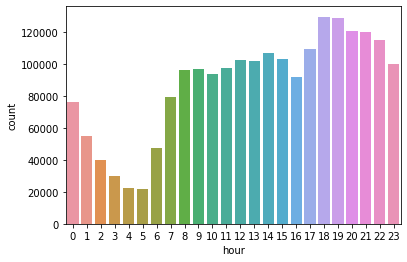

In [19]:
sns.countplot(df['hour'])

> 픽업이 새벽에는 매우 낮고 6시~8시 사이에 제일 높은것을 알 수 있다

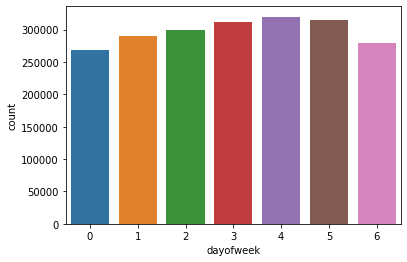

In [20]:
sns.countplot(df['dayofweek'])

> 픽업이 월요일에 제일 낮은것을 볼 수 있다.

### d.거리 변수 <a id="two-d"></a>

In [21]:
df['dist_long'] = df['pickup_longitude'] - df['dropoff_longitude']
df['dist_lat'] = df['pickup_latitude'] - df['dropoff_latitude']

In [22]:
df['dist'] = np.sqrt(np.square(df['dist_long']) + np.square(df['dist_lat']))

>미터기가 시작되고 끝난 각각의 경도 위도만큼 빼준다음에 총 합계를 구해서 새로운 파생변수를 만들었다

하버사인 공식(Haversine Formula) 은 주어진 지점에 대해 구 (Sphere) 의 두 지점 사이의 최단거리(great-circle distance) 를 구하는 공식이다.

$$ 2rarcsin\sqrt{\sin^2(\frac{φ_2 -φ_1}{2}) + cos(φ_1)cos(φ_2)sin^2(\frac{λ_2 -λ_1}{2})} $$

In [23]:
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

df['distance'] = ft_haversine_distance(df['pickup_latitude'].values,
                                       df['pickup_longitude'].values, 
                                       df['dropoff_latitude'].values,
                                       df['dropoff_longitude'].values)

>두 위도와 경도 사이의 거리를 구하는 공식으로 하버사인 공식을 사용해서 거리 피처를 구해줍니다.

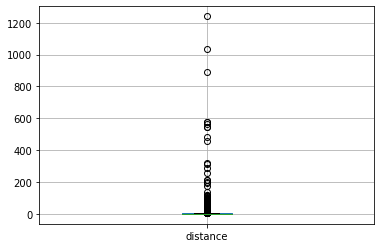

In [24]:
df.boxplot(column='distance')

In [25]:
#df = df[(df.distance < 200)]

>boxplot 확인 결과 이상치 제거를 해줍니다.

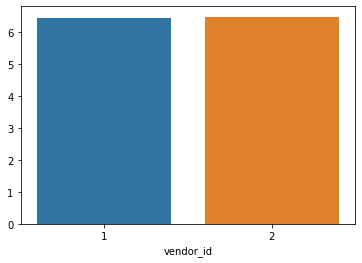

In [26]:
g_vendor = train.groupby('vendor_id')['trip_duration'].mean()
sns.barplot(g_vendor.index,g_vendor.values)

> 공급업체 별로 그룹바이를 한 상태에서 타겟변수를 확인해본 결과 별 차이는 없는것같다

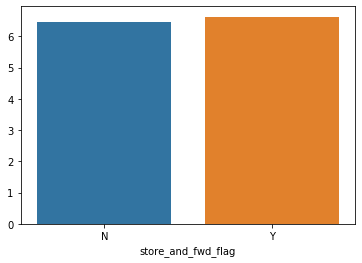

In [27]:
sfflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()
sns.barplot(sfflag.index,sfflag.values)

>'store_and_fwd_flag'는 여행 시간을 잘 구별하는 것처럼 보인다

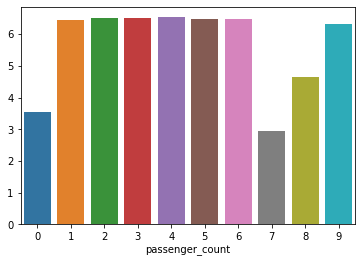

In [28]:
pc = train.groupby('passenger_count')['trip_duration'].mean()
sns.barplot(pc.index,pc.values)

### e. 범주형 변수 원핫 인코딩<a id="two-e"></a>

In [29]:
df = pd.concat([df, pd.get_dummies(df['store_and_fwd_flag'],prefix = 'store')], axis=1)
df.drop(['store_and_fwd_flag'], axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['vendor_id'],prefix = 'vendor')], axis=1)
df.drop(['vendor_id'], axis=1, inplace=True)

In [30]:
df.head(3)

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,day,weekday,hour,dayofweek,dist_long,dist_lat,dist,distance,store_N,store_Y,vendor_1,vendor_2
0,id2875421,1,-73.982155,40.767937,-73.964630,40.765602,3,14,0,17,0,-0.017525,0.002335,0.017680,1.498521,1,0,0,1
1,id2377394,1,-73.980415,40.738564,-73.999481,40.731152,6,12,6,0,6,0.019066,0.007412,0.020456,1.805507,1,0,1,0
2,id3858529,1,-73.979027,40.763939,-74.005333,40.710087,1,19,1,11,1,0.026306,0.053852,0.059934,6.385098,1,0,0,1


### f. 상관 관계<a id="two-f"></a>

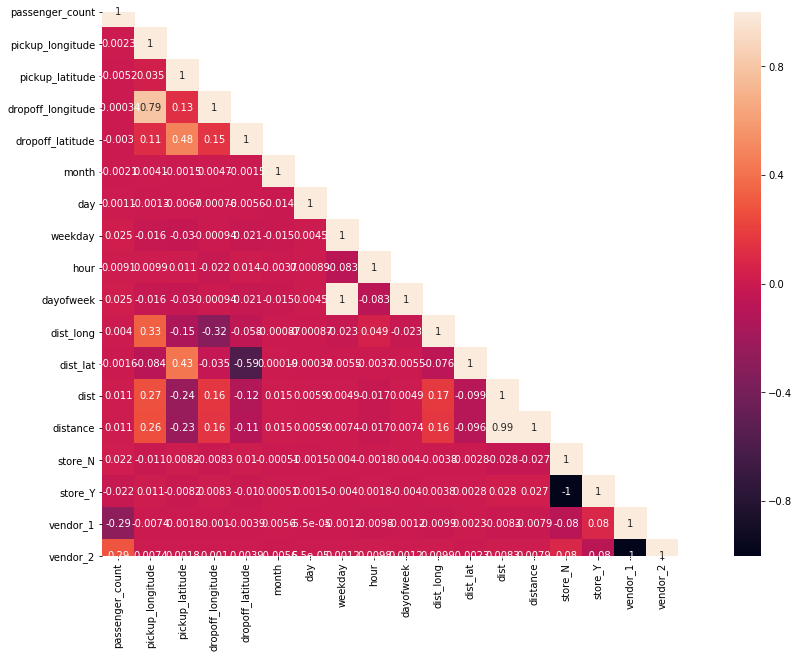

In [31]:
cor = df.corr()
mask = np.array(cor)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(cor,mask= mask,square=True,annot=True)

## III. 모델링 <a id="three"></a>

In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

### a. train_test_split <a id="three-a"></a>

In [34]:
df.head(3)

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,day,weekday,hour,dayofweek,dist_long,dist_lat,dist,distance,store_N,store_Y,vendor_1,vendor_2
0,id2875421,1,-73.982155,40.767937,-73.964630,40.765602,3,14,0,17,0,-0.017525,0.002335,0.017680,1.498521,1,0,0,1
1,id2377394,1,-73.980415,40.738564,-73.999481,40.731152,6,12,6,0,6,0.019066,0.007412,0.020456,1.805507,1,0,1,0
2,id3858529,1,-73.979027,40.763939,-74.005333,40.710087,1,19,1,11,1,0.026306,0.053852,0.059934,6.385098,1,0,0,1


In [35]:
df.drop(["id"], axis=1, inplace=True)

In [36]:
new_train = df[:train.shape[0]]
new_test = df[train.shape[0]:]

In [37]:
target = train['trip_duration']

In [38]:
X_train, X_val, y_train, y_val = train_test_split(new_train, target, test_size=0.2, shuffle=True)

### b. RMSLE <a id="three-b"></a>

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$
${n}$ is the number of hours in the test set
$p_i$ is your predicted count
$a_i$ is the actual count
$\log(x)$ is the natural logarithm

In [39]:
def rmsle_score(preds, true):
    rmsle_score = (np.sum((np.log1p(preds)-np.log1p(true))**2)/len(true))**0.5
    return rmsle_score

In [40]:
from sklearn.metrics.scorer import make_scorer

RMSLE = make_scorer(rmsle_score)

### c. 통계 확인 <a id="three-c"></a>

In [41]:
import statsmodels.api as sm

In [42]:
model = sm.OLS(target.values, new_train.astype(float))

In [43]:
re = model.fit()
re.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                 5.721e+04
Date:                Fri, 29 May 2020   Prob (F-statistic):               0.00
Time:                        20:48:56   Log-Likelihood:            -1.4430e+06
No. Observations:             1458644   AIC:                         2.886e+06
Df Residuals:                 1458630   BIC:                         2.886e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
passenger_count       0.0074      0.000     17.165      0.000       0.007       0.008
pickup_longitude     -0.4393      0.006    -74.171      0.000      -0.451      -0.428
pickup_latitude      -0.4808      0.011    -42.122      0.000      -0.503      -0.458
dropoff_longitude     0.2161      0.006     38.047      0.000       0.205       0.227
dropoff_latitude     -0.6385      0.010    -62.006      0.000      -0.659      -0.618
month                 0.0178      0.000     55.435      0.000       0.017       0.018
day                   0.0007   6.19e-05     10.729      0.000       0.001       0.001
weekday              -0.0063      0.000    -45.347      0.000      -0.007      -0.006
hour                  0.0061   8.46e-05     72.132      0.000       0.006       0.006
dayofweek            -0.0063      0.000    -45.347      0.000      -0.007      -0.006
dist_long            -0.6554      0.008    -82.045      0.000      -0.671      -0.640
dist_lat              0.1578      0.011     14.995      0.000       0.137       0.178
dist                 -0.9781      0.110     -8.894      0.000      -1.194      -0.763
distance              0.1182      0.001    101.227      0.000       0.116       0.120
store_N              17.5265      0.536     32.709      0.000      16.476      18.577
store_Y              17.5372      0.536     32.730      0.000      16.487      18.587
vendor_1             17.5219      0.536     32.701      0.000      16.472      18.572
vendor_2             17.5418      0.536     32.738      0.000      16.492      18.592
==============================================================================
Omnibus:                  2500235.096   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     153025119387.063
Skew:                         -10.420   Prob(JB):                         0.00
Kurtosis:                    1589.627   Cond. No.                     1.27e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.33e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

>모델의 설명력이 0.338이며 각 피처의 p-value가 0.0000으로 유의수준 5%보다 낮았으며 
다중공선성의 문제는 없는것으로 보인다

### d. lightgbm <a id="three-d"></a>

In [45]:
import lightgbm as lgbm

In [46]:
lgb_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }


In [47]:
lgb_df = lgbm.Dataset(new_train,target)

In [49]:
lgb_model = lgbm.train(lgb_params, lgb_df, num_boost_round=1500)

In [50]:
pred = lgb_model.predict(new_test)

In [51]:
pred_lgb = np.exp(pred)

### e. xgboost <a id="three-d"></a>

In [52]:
import xgboost as xgb

In [53]:
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.1,
    'max_depth':          14,
    'subsample':          0.8,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1
}

In [54]:
dtrain = xgb.DMatrix(new_train, target)

In [55]:
gbm = xgb.train(params,
                dtrain,
                num_boost_round = 200)

In [56]:
pred_test = np.exp(gbm.predict(xgb.DMatrix(new_test)))

## IV. 예측 <a id="four"></a>

### a.앙상블 <a id="four-a"></a>

In [57]:
#ensemble = (0.8*pred_lgb + 0.4*pred_test) 0.42295
#ensemble = (0.7*pred_lgb + 0.3*pred_test) 0.38148
ensemble = (0.6*pred_lgb + 0.4*pred_test) #0.38124
#ensemble = (0.55*pred_lgb + 0.45*pred_test) 0.38126

In [109]:
sub = pd.DataFrame()
sub['id'] = test.id
sub['trip_duration'] = ensemble
sub.head(3)

,id,trip_duration
0,id3004672,750.546320
1,id3505355,568.559134
2,id1217141,445.803180
3,id2150126,955.190497
4,id1598245,360.586044


In [58]:
sub = pd.DataFrame()
sub['id'] = test.id
sub['trip_duration'] = ensemble
sub.head(3)

,id,trip_duration
0,id3004672,750.228478
1,id3505355,565.720495
2,id1217141,444.530588


In [59]:
sub.to_csv('submission.csv', index=False)